In [102]:
import tensorflow as tf
from tensorflow import keras

In [103]:
print(tf.__version__)
print(keras.__version__)
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

2.0.0-beta1
2.2.4-tf
True
True


In [104]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15862197606652411644
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4838588416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14125630025688413475
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [105]:
os.cpu_count()

12

In [106]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

Memory growth must be set at program startup


In [107]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices must be set at program startup


In [202]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [109]:
import argparse
import locale
import os
import numpy as np
from numpy import dstack,vstack
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy.misc
import cv2
from tqdm import tqdm_notebook
from pandas import DataFrame
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
# import statsmodels.api as sm
# from matplotlib.mlab import bivariate_normal
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

from keras.constraints import maxnorm
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, GlobalAveragePooling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras import callbacks,  models
from keras import applications
from keras.applications import vgg16, vgg19, InceptionV3 ,ResNet152
from keras.models import load_model
from keras.utils import plot_model

%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score
import time
from vecstack import stacking
from sklearn.metrics import accuracy_score
from sklearn import neighbors, tree
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix,cohen_kappa_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import winsound
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection._search import BaseSearchCV

ModuleNotFoundError: No module named 'tqdm'

# 새로운 데이터 테스트 용

In [111]:
%time sum(range(10000))
cwd = os.getcwd()
#dir_name = 'image/classification/'
dir_name = 'text_folder/dataset_revised/classification_sigma_allfeature_mix/'
path = cwd + '/' + dir_name # 경로 추적
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path)) # data 폴더 안에 있는 폴더 명
ncategories = len(categories)
print(categories)
valid_extscsv = [".csv"]
valid_extsimg = [".jpg", ".gif", ".png", ".jpeg"]
where = []
imgs = []
labels = []
labelscsv = []
dfs = []
num = 0

with tf.device("/cpu:0"):
    def imread(path):
        img = scipy.misc.imread(path).astype(np.float)
        if len(img.shape) == 2:
            img = np.transpose(np.array([img, img, img]), (2, 0, 1))
        return img

    for i, category in enumerate(categories):
        iter = 0
        for file in os.listdir(path + '/'+ category):
            if iter == 0:
                ext = os.path.splitext(file)[1]
                if ext.lower() not in valid_extscsv:
                    continue
                #fullpath = os.path.join(path + category, file)
                #here = os.path.join("/" + category, file)
                #where.append(here)
                df = pd.read_csv(dir_name + category+'/'+file,usecols=['Left Mean Pressure','Left Sum Pressure','Left Area','Left Rear Sum','Left Sub Area'
                                                                      ,'Right Mean Pressure','Right Sum Pressure','Right Area','Right Rear Sum','Right Sub Area'])
                df = np.array(df)
                dfs.append(df)

                label_csv = i
                labelscsv.append(label_csv)

    # LOAD ALL IMAGES
    for i, category in enumerate(categories):
        iter = 0
        for file in os.listdir(path + '/'+ category):
            if iter == 0:
                ext = os.path.splitext(file)[1]
                if ext.lower() not in valid_extsimg:
                    continue
                #fullpath = os.path.join(path + category, file)
                #here = os.path.join("/" + category, file)
                #where.append(here)
                img = cv2.imread(dir_name + category+'/'+file,1) #왜 경로를 현재파일 이후로 지정해야 gray스케일이 나오는지는 알아봐야함
                #img = scipy.misc.imread(dir_name + category+'/'+file).astype(np.int32)
    #             img = cv2.resize(img, [32,32,3])
                img = cv2.resize(img,(224,224),interpolation = cv2.INTER_CUBIC)
                #img = img.astype('int32')
                img = img.astype('float32')
                img = (img - np.mean(img))/np.std(img)
                imgs.append(img) # NORMALIZE IMAGE a

                label_curr = i
                labels.append(label_curr)

    print ("Num imgs: %d" % (len(imgs)))
    print ("Num labels: %d" % (len(labels)))
    print (ncategories)
    print(imgs[12].shape)

Wall time: 1 ms


FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'c:\\Users\\user\\git_project/text_folder/dataset_revised/classification_sigma_allfeature_mix/'

# dfs 데이터 합치기(분류 1~9까지 합침)

In [112]:
dfs0 = pd.DataFrame(dfs[0])
dfs1 = pd.DataFrame(dfs[1])
dfs2 = pd.DataFrame(dfs[2])
dfs3 = pd.DataFrame(dfs[3])
dfs4 = pd.DataFrame(dfs[4])
dfs5 = pd.DataFrame(dfs[5])
dfs6 = pd.DataFrame(dfs[6])
dfs7 = pd.DataFrame(dfs[7])
dfs8 = pd.DataFrame(dfs[8])

dfa = pd.concat([dfs0,dfs1,dfs2,dfs3,dfs4,dfs5,dfs6,dfs7,dfs8])
dfa = dfa.reset_index(drop=True)
dfa.columns = ['Left Max Pressure','Left Mean Pressure','Left std','Left Sum Pressure','Left Kurtosis','Left Skewness','Left Area','Left Arch index','Left width','Left length','Right Max Pressure','Right Mean Pressure','Right std','Right Sum Pressure','Right Kurtosis','Right Skewness','Right Area','Right Arch index','Right width','Right length']

NameError: name 'dfs' is not defined

# dfs 데이터 합치기(분류 1~9까지 합침) 데이터 확인 수정용

In [113]:
dfs0 = pd.DataFrame(dfs[0])
dfs1 = pd.DataFrame(dfs[1])
dfs2 = pd.DataFrame(dfs[2])
dfs3 = pd.DataFrame(dfs[3])
dfs4 = pd.DataFrame(dfs[4])
dfs5 = pd.DataFrame(dfs[5])
dfs6 = pd.DataFrame(dfs[6])
dfs7 = pd.DataFrame(dfs[7])
dfs8 = pd.DataFrame(dfs[8])

dfa = pd.concat([dfs0,dfs1,dfs2,dfs3,dfs4,dfs5,dfs6,dfs7,dfs8])
dfa = dfa.reset_index(drop=True)
dfa.columns = ['Left Mean Pressure','Left Sum Pressure','Left Area','Left Rear Sum','Left Sub Area'
                                                                      ,'Right Mean Pressure','Right Sum Pressure','Right Area','Right Rear Sum','Right Sub Area']

NameError: name 'dfs' is not defined

# 표준 정규화

In [114]:
# dfa['Left Max Pressure'] = (dfa['Left Max Pressure'] - dfa['Left Max Pressure'].mean()) / dfa['Left Max Pressure'].std()
dfa['Left Mean Pressure'] = (dfa['Left Mean Pressure'] - dfa['Left Mean Pressure'].mean()) / dfa['Left Mean Pressure'].std()
# dfa['Left Median Pressure'] = (dfa['Left Median Pressure'] - dfa['Left Median Pressure'].mean()) / dfa['Left Median Pressure'].std()
dfa['Left Sum Pressure'] = (dfa['Left Sum Pressure'] - dfa['Left Sum Pressure'].mean()) / dfa['Left Sum Pressure'].std()
dfa['Left Area'] = (dfa['Left Area'] - dfa['Left Area'].mean()) / dfa['Left Area'].std()
# dfa['Left Front Sum'] = (dfa['Left Front Sum'] - dfa['Left Front Sum'].mean()) / dfa['Left Front Sum'].std()
dfa['Left Rear Sum'] = (dfa['Left Rear Sum'] - dfa['Left Rear Sum'].mean()) / dfa['Left Rear Sum'].std()
# dfa['Left width'] = (dfa['Left width'] - dfa['Left width'].mean()) / dfa['Left width'].std()
# dfa['Left length'] = (dfa['Left length'] - dfa['Left length'].mean()) / dfa['Left length'].std()
dfa['Left Sub Area'] = (dfa['Left Sub Area'] - dfa['Left Sub Area'].mean()) / dfa['Left Sub Area'].std()

# dfa['Right Max Pressure'] = (dfa['Right Max Pressure'] - dfa['Right Max Pressure'].mean()) / dfa['Right Max Pressure'].std()
dfa['Right Mean Pressure'] = (dfa['Right Mean Pressure'] - dfa['Right Mean Pressure'].mean()) / dfa['Right Mean Pressure'].std()
# dfa['Right Median Pressure'] = (dfa['Right Median Pressure'] - dfa['Right Median Pressure'].mean()) / dfa['Right Median Pressure'].std()
dfa['Right Sum Pressure'] = (dfa['Right Sum Pressure'] - dfa['Right Sum Pressure'].mean()) / dfa['Right Sum Pressure'].std()
dfa['Right Area'] = (dfa['Right Area'] - dfa['Right Area'].mean()) / dfa['Right Area'].std()
# dfa['Right Front Sum'] = (dfa['Right Front Sum'] - dfa['Right Front Sum'].mean()) / dfa['Right Front Sum'].std()
dfa['Right Rear Sum'] = (dfa['Right Rear Sum'] - dfa['Right Rear Sum'].mean()) / dfa['Right Rear Sum'].std()
# dfa['Right width'] = (dfa['Right width'] - dfa['Right width'].mean()) / dfa['Right width'].std()
# dfa['Right length'] = (dfa['Right length'] - dfa['Right length'].mean()) / dfa['Right length'].std()
dfa['Right Sub Area'] = (dfa['Right Sub Area'] - dfa['Right Sub Area'].mean()) / dfa['Right Sub Area'].std()

NameError: name 'dfa' is not defined

In [115]:
dfa.describe()

NameError: name 'dfa' is not defined

# 흑백 이미지 사용할 때

In [116]:
plt.imshow(imgs[333])
gray_imgs = np.expand_dims(imgs,axis=3)
print(gray_imgs[1].shape)
plt.show()

NameError: name 'imgs' is not defined

# MLP 모델 입,출력 변수 선언 및 데이터 분할

In [117]:
with tf.device("/cpu:0"):
    from sklearn.preprocessing import OneHotEncoder
    X=np.array(imgs)
    y=np.array(labels)
    x = np.array(dfa.iloc[:,[0,1,3,5,6,8]])

    Y_class = np.array(y).reshape(-1,1)
    enc = OneHotEncoder()
    enc.fit(Y_class)
    Y_class_onehot = enc.transform(Y_class).toarray()
    Y_class_recovery = np.argmax(Y_class_onehot, axis=1)

    # NB_CLASSES = int(max(y)+1)
    # y_one_hot = np_utils.to_categorical(y, NB_CLASSES)

    X_train, X_test,x_train,x_test, Y_train, Y_test = train_test_split(X,x,Y_class_onehot,test_size=0.2,random_state=42)
#     X_train, X_test,Y_train, Y_test = train_test_split(np.array(X),Y_class_onehot,test_size=0.2,random_state=42)
    # xy = (X_train, X_test, Y_train, Y_test)
    # np.save("./img_data.npy", xy)

NameError: name 'imgs' is not defined

In [118]:
plt.imshow(imgs[0])

NameError: name 'imgs' is not defined

# MLP gridsearch

In [119]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
mlp = MLPClassifier(max_iter=100)
from sklearn.preprocessing import StandardScaler

start_time = time.time()

parameter_space = {
    'hidden_layer_sizes': [(40,20),(100),(100,200), (100,100), (200,200)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001,0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(x_train, Y_train)

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))


# 스케일링 : 표준화 ( 자료를 평균 0 , 분산 1이 되도록 전처리 ) 
# - 안정성, 수렴속도 향상, 정확도 향상등의 효과를 얻을 수 있다. [출처] [190617] 퍼셉트론/ MLP/ 하둡(Hadoop)|작성자 천프로

sc = StandardScaler() 
sc.fit(x_train)
sc.fit(x_test)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

y_true, y_pred = Y_test , clf.predict(x_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

print('run time :',round(time.time()-start_time,3))

NameError: name 'time' is not defined

# Meta dataset

In [120]:
train_meta = pd.DataFrame(columns = ['MLP','CNN'])
test_meta = pd.DataFrame(columns = ['MLP','CNN'])

# MLP Layers

In [121]:
from sklearn.ensemble import BaggingClassifier

In [122]:
def mlp_model(dense1,dense2,dropout_rate):
    MLP = Sequential()
    MLP.add(Dense(18, input_dim=18, activation="relu", kernel_initializer="he_normal"))
    MLP.add(Dense(dense1, activation="relu", kernel_initializer="he_normal"))
    MLP.add(Dense(dense2, activation="relu", kernel_initializer="he_normal"))
    MLP.add(Dropout(dropout_rate))
    MLP.add(BatchNormalization())
    MLP.add(Dense(9, activation="softmax", kernel_initializer="he_normal"))
    # Compile model
    MLP.compile(loss='categorical_crossentropy', optimizer= Adam(lr=0.002), metrics=['accuracy'])
#     MLP.summary()
    ## Fit the model
    return MLP

In [123]:
MLP_search_point = {'dense1': (1,9,1),
                    'dense2':(1,9,1),
                    'dropout_rate':(0.1,0.5)}

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)
gp_params = {"alpha":1e-10}

def MLP_opt(dense1,dense2,dropout_rate):
    start_time = time.time()
    cvscores = []
    
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
        model = mlp_model(int(dense1),int(dense2),float(dropout_rate))
#         X_skftrain, X_val = X[train_index],X[val_index]       
        x_skftrain, x_val = x[train_index],x[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        model.fit(x_skftrain,Y_skftrain, batch_size=2000, epochs=200,verbose=0)
#         score = cnn.evaluate(X_val,Y_val,verbose=0)
#         cvscores.append(score[1]*100)
        
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(model.predict(x_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(model.predict(x_val),axis=1)))
        
        cvscores.append(f1scores*100)
    
    print('time',round(time.time()-start_time,3)/60)

    return np.mean(cvscores)


# if __name__ == "__main__":
result = BayesianOptimization(MLP_opt, MLP_search_point,    random_state=10,    verbose=2) 
result.maximize(acq='ucb',n_iter=10, kappa=3, init_points=3 , **gp_params)
#     for i, res in enumerate(result.res):
#         print('Iteration {}: \n\t{}'.format(i, res))
#         print('Final result: ', result.max)

frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration) #cell 결과내고 확인 할 때 beep 소리 내는 기능

NameError: name 'StratifiedKFold' is not defined

# k opt

In [124]:
MLP_search_point = {'k': (1,1000)}
                   

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)
gp_params = {"alpha":1e-10}
time_all = []
scores_all = []
k_all = []
def MLP_opt(k):
    start_time = time.time()
    cvscores = []
    
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
        model = KNeighborsClassifier(n_neighbors = int(k),weights = 'uniform') # KNN
#         model = tree.DecisionTreeClassifier(max_depth=k, min_samples_leaf=250, min_samples_split=9) #CART
#         X_skftrain, X_val = X[train_index],X[val_index]       
        x_skftrain, x_val = x[train_index],x[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        model = model.fit(x_skftrain,Y_skftrain)
        
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(model.predict(x_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(model.predict(x_val),axis=1)))
        
        cvscores.append(f1scores)
    
    print('time',round(time.time()-start_time,3)/60)

    time_all.append(round(time.time()-start_time,3)/60)
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    return np.mean(cvscores)


# if __name__ == "__main__":
result = BayesianOptimization(MLP_opt, MLP_search_point,    random_state=10,    verbose=2) 
result.maximize(acq='ucb',n_iter=10, kappa=2.576, init_points=5 , **gp_params)
#     for i, res in enumerate(result.res):
#         print('Iteration {}: \n\t{}'.format(i, res))
#         print('Final result: ', result.max)

frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration) #cell 결과내고 확인 할 때 beep 소리 내는 기능

NameError: name 'StratifiedKFold' is not defined

In [125]:
scores_all

NameError: name 'scores_all' is not defined

In [126]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
# Define Kernel Function
kernel = kernels.Matern()

# Define Model
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=0.1, normalize_y=False)
model.fit(np.array(k_all).reshape(-1, 1), np.array(scores_all).reshape(-1,1))
params = model.get_params()

mu_s, std_s = model.predict(X, return_std=True)


NameError: name 'k_all' is not defined

In [127]:
from scipy import stats
from scipy.stats import norm

from sklearn.gaussian_process import GaussianProcessRegressor, kernels
# Define Kernel Function
kernel = kernels.Matern()

# Define Model
model = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=False)
# model.fit(np.array(k_all).reshape(-1, 1), np.array(time_all).reshape(-1,1))
model.fit(np.array(k_all).reshape(-1, 1), np.array(scores_all).reshape(-1,1))
params = model.get_params()


plt.figure(figsize = (10,5) )
plt.style.use('ggplot')

# plt.scatter(k_all,time_all,color='green', marker='o')
plt.scatter(k_all,scores_all,color = 'b',marker='o')
xmin, xmax = plt.xlim()
X = np.linspace(xmin, xmax, 100)
X = np.atleast_2d(X).T
mu_s, std_s = model.predict(X, return_std=True)

plt.plot(X, mu_s, label='Predicted', color ='r',linestyle=':')

# plt.legend(labels=['Predicted','Time[min]'])
plt.legend(labels=['Predicted','f1 scores'])

plt.title('CART Model',{'fontsize' : 20})

# plt.ylabel('Computation Time[min]',{'fontsize' : 20})
plt.ylabel('F1 score',{'fontsize' : 20})

plt.xlabel('Max Depth',{'fontsize' : 20})
plt.show()

NameError: name 'k_all' is not defined

In [128]:
bag_MLP = BaggingClassifier(mlp_model(),n_estimators=100,max_samples=10000,bootstrap=True, n_jobs=-1, random_state=42)

TypeError: mlp_model() missing 3 required positional arguments: 'dense1', 'dense2', and 'dropout_rate'

# image generator

In [129]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode= 'nearest')

val_datagen = ImageDataGenerator()

ModuleNotFoundError: No module named 'keras'

In [130]:
train_generator = train_datagen.flow(X_train,Y_train,batch_size=100)
val_generator = val_datagen.flow(X_test,Y_test,batch_size=25)

NameError: name 'train_datagen' is not defined

# VGG16 Model

In [131]:
from keras.applications import vgg16, InceptionV3 ,ResNet152
from keras import models

vgg_conv = vgg16.VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(32, 32, 3)
                )

for layer in vgg_conv.layers:
    layer.trainable = False

# for layer in vgg_conv.layers[:-4]:
#     layer.trainable = False

# Check the trainable status of the individual layers
# for layer in vgg_conv.layers:
#     print(layer, layer.trainable)
    
 
 
# Add new layers
model = Sequential() 
model.add(vgg_conv) 
model.add(Flatten()) 
model.add(Dense(512, activation='relu', name='Dense_Intermediate')) 
model.add(BatchNormalization())
model.add(Dropout(0.5, name='Dropout_Regularization')) 
model.add(Dense(9, activation='softmax', name='Output'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

ModuleNotFoundError: No module named 'keras'

In [132]:

# Train the model
history = model.fit(
      X_train,Y_train,
      epochs=10,
      validation_data=(X_test,Y_test),
      verbose=1)
 
# Save the model
model.save('small_last4.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: name 'X_train' is not defined

In [133]:
def vgg16_model(learning_rate,dense_node,dropout_rate):
    
    vgg_conv = vgg16.VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3)
                )

    for layer in vgg_conv.layers:
        layer.trainable = False

    # for layer in vgg_conv.layers[:-4]:
    #     layer.trainable = False

    # Check the trainable status of the individual layers
    # for layer in vgg_conv.layers:
    #     print(layer, layer.trainable)



    # Add new layers
    model = Sequential() 
    model.add(vgg_conv) 
    model.add(Flatten()) 
    model.add(Dropout(0.5, name='Dropout_Regularization')) 
    model.add(Dense(81, activation='relu', name='Dense_Intermediate')) 
    model.add(BatchNormalization())
    model.add(Dense(9, activation='softmax', name='Output'))

    # Show a summary of the model. Check the number of trainable parameters
    # Compile the model
    model.compile(optimizer=Adam(lr=1e-5,epsilon=1e-07), loss='categorical_crossentropy', metrics=['accuracy'] )

#     model.summary()
    return model

In [134]:
pd.set_option('display.max_rows',1000)

In [135]:
input_tensor = Input(shape=(224,224, 3))  # this assumes K.image_data_format() == 'channels_last'
prior = applications.vgg16.VGG16( input_tensor=input_tensor,weights='imagenet',include_top=False, classes = 9)  

for cnn_block_layer in prior.layers[:-3]: 
    cnn_block_layer.trainable = False 

layers = [(layer, layer.name, layer.trainable) for layer in prior.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

NameError: name 'Input' is not defined

In [136]:
def InceptionV3(learning_rate,dense_node,dropout_rate):
    input_tensor = Input(shape=(224,224, 3))  # this assumes K.image_data_format() == 'channels_last'
    prior = applications.vgg19.VGG19( input_tensor=input_tensor,weights='imagenet',include_top=False, classes = 9)  
    
    for cnn_block_layer in prior.layers[:-4]:
        cnn_block_layer.trainable = False 
        
    CNN_model = Sequential() 
    CNN_model.add(prior) 
    CNN_model.add(Flatten())
    CNN_model.add(Dropout(0.5, name='Dropout_Regularization')) 
    CNN_model.add(Dense(81, activation='relu', name='Dense_Intermediate')) 
    CNN_model.add(BatchNormalization())
    CNN_model.add(Dense(9, activation='softmax', name='Output'))

#     for cnn_block_layer in CNN_model.layers[0].layers: 
#         cnn_block_layer.trainable = False 
#     CNN_model.layers[0].trainable = False 

#     CNN_model.compile(optimizer=RMSprop(lr=1e-6), loss='categorical_crossentropy', metrics=['accuracy'] )
    CNN_model.compile(optimizer=RMSprop(lr=1e-6,epsilon=1e-07), loss='categorical_crossentropy', metrics=['accuracy'] )
#     CNN_model.summary()
    return CNN_model

In [137]:
def ResNet152(learning_rate,dense_node,dropout_rate):
    input_tensor = Input(shape=(224, 224, 3))  # K.image_data_format() == 'channels_last'라고 가정합니다
    prior = applications.resnet50.ResNet50( input_tensor=input_tensor,weights='imagenet',include_top=False, classes = 9)  
    
    for cnn_block_layer in prior.layers:
        cnn_block_layer.trainable = False 
        
    CNN_model = Sequential() 
    CNN_model.add(prior) 
    CNN_model.add(Flatten())
    CNN_model.add(Dense(1024, activation='relu', name='Dense_Intermediate')) 
    CNN_model.add(BatchNormalization())
    CNN_model.add(Dense(1024, activation='relu', name='Dense_Intermediate2')) 
    CNN_model.add(Dropout(0.7, name='Dropout_Regularization')) 
    CNN_model.add(Dense(9, activation='softmax', name='Output'))

#     for cnn_block_layer in CNN_model.layers[0].layers: 
#         cnn_block_layer.trainable = False 
#     CNN_model.layers[0].trainable = False 

    CNN_model.compile(optimizer=Adam(lr=1e-6,epsilon=1e-07), loss='categorical_crossentropy', metrics=['accuracy'] )
#     CNN_model.summary()
    return CNN_model

In [138]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rotation_range = 0, zca_whitening=True, shear_range=0.05,
    zoom_range=0.05,width_shift_range=0.05, height_shift_range=0.05)

data_flow = generator.flow(X_train,Y_train, batch_size = 50)
data_valflow = generator.flow(X_test,Y_test, batch_size = 50)

ModuleNotFoundError: No module named 'keras'

In [139]:
RES = InceptionV3(0.08492 ,18,0.3161)
RES_history =[]

# RES_history.append(RES.fit(X_train, Y_train ,epochs=10, batch_size=100, validation_data=(X_test, Y_test),verbose=2))

# skfolds=StratifiedKFold(n_splits=2, random_state=42,shuffle =True)
# Y_train_recovery = np.argmax(Y_train, axis=1)

# for train_index, val_index in skfolds.split(x, Y_class_recovery):
#         cnn = ResNet152(float(0.08492),int(18),float(0.3161))
#         X_skftrain, X_val = X[train_index],X[val_index]
#         Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

#         RES_history.append(cnn.fit_generator(data_flow, epochs=25, steps_per_epoch=300,
#                           verbose=2, validation_data=data_valflow,validation_steps = 2000))
        
RES_history.append(RES.fit_generator(data_flow, epochs=20,steps_per_epoch = 100,
                           verbose=2, validation_data=data_valflow,validation_steps = 100))
f1scores = f1_score(np.argmax(Y_test,axis=1),np.argmax(RES.predict(X_test),axis=1),average = 'weighted',labels=np.unique(np.argmax(RES.predict(X_test),axis=1)))

NameError: name 'Input' is not defined

In [140]:
print(f1scores)

NameError: name 'f1scores' is not defined

In [141]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

def plot_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)
    
def main():
    batch_size = 100
    epochs = 10
 
    model = ResNet152(1,1,1)
    

    history = model.fit_generator(data_flow, epochs=epochs, steps_per_epoch=10,
                                  verbose=2, validation_data=(X_test, Y_test))
 
    performance_test = model.evaluate(X_test, Y_test, batch_size=100,
        verbose=0)
    print('\nTest Result ->', performance_test)
 
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()
    
    
if __name__ == '__main__':
    main()

NameError: name 'Input' is not defined

In [142]:
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop, Nadam, Adamax, Adagrad, Adadelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization



CNN_search_point = {'learning_rate': (0.0001,0.1),
                  'dense_node':(1,1024),
                  'dropout_rate':(0.01,0.50)}

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)

def CNN_opt(learning_rate,dense_node,dropout_rate):
    start_time = time.time()
    cvscores = []
    
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
        cnn = ResNet152(float(learning_rate),int(dense_node),float(dropout_rate))
        X_skftrain, X_val = X[train_index],X[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        cnn.fit(X_skftrain,Y_skftrain,batch_size=1000, epochs=50,verbose=0)
#         score = cnn.evaluate(X_val,Y_val,verbose=0)
#         cvscores.append(score[1]*100)
        
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(cnn.predict(X_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(cnn.predict(X_val),axis=1)))
        
        cvscores.append(f1scores*100)
    
    print('time',round(time.time()-start_time,3)/60)

    return np.mean(cvscores)


if __name__ == "__main__":
    result = BayesianOptimization(CNN_opt, CNN_search_point,    random_state=10,    verbose=2) 
    result.maximize(acq='ucb',n_iter=3)
    for i, res in enumerate(result.res):
        print('Iteration {}: \n\t{}'.format(i, res))
        print('Final result: ', result.max)

frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration) #cell 결과내고 확인 할 때 beep 소리 내는 기능

ModuleNotFoundError: No module named 'keras'

# k - opt

In [143]:
seed = 7
np.random.seed(seed)

skfolds=StratifiedKFold(n_splits=2, random_state=42,shuffle =True)
kfolds = KFold(5,shuffle=True)

KNN_history = []
KNN_cvscores = []
KNN_time = []
for k in range(1001,10000,2000):
    start_time = time.time()
    print(k)
    small_scores = []
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
#         print('%d'%k[i],'train data:', len(train_index), 'validation data:', len(val_index))
        x_skftrain, x_val = x[train_index],x[val_index]
#         X_skftrain, X_val = X[train_index],X[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        KNN = KNeighborsClassifier(n_neighbors=k, weights = 'distance',leaf_size=500)
        modelknn = KNN.fit(x_skftrain, Y_skftrain)
        scorestr = modelknn.score(x_skftrain,Y_skftrain)
        scores = modelknn.score(x_val,Y_val)
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(modelknn.predict(x_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(modelknn.predict(x_val),axis=1)))
        kappa_score = cohen_kappa_score(np.argmax(Y_val,axis=1),np.argmax(modelknn.predict(x_val),axis=1),labels=np.unique(np.argmax(modelknn.predict(x_val),axis=1)))
        
        print('tr',scorestr,'te',scores)
        print(kappa_score)
        small_scores.append(f1scores)

    knntime = time.time()
    print('KNN run time :',round(knntime-start_time,3)/60)
    print(np.mean(small_scores))
    
    KNN_cvscores.append(np.mean(small_scores))
    KNN_time.append(round(knntime-start_time,3)/60)

plt.figure(figsize=(20,10))
plt.plot(KNN_cvscores)
plt.title('KNN model',{'fontsize' : 20})
plt.ylabel('f1_score',{'fontsize' : 20})
plt.xlabel('k number',{'fontsize' : 20})
plt.show()


frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration) #cell 결과내고 확인 할 때 beep 소리 내는 기능

NameError: name 'StratifiedKFold' is not defined

# max_depth - opt

In [144]:
seed = 7
np.random.seed(seed)

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)
kfolds = KFold(5,shuffle=True)

CART_history = []
CART_cvscores = []
CART_time = []
for k in range(1,30):
    start_time = time.time()
    print(k)
    small_scores = []
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
#         print('%d'%k[i],'train data:', len(train_index), 'validation data:', len(val_index))
        x_skftrain, x_val = x[train_index],x[val_index]
#         X_skftrain, X_val = X[train_index],X[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        CART = tree.DecisionTreeClassifier(max_depth=k,min_samples_leaf=250,min_samples_split=9)
        modelCART = CART.fit(x_skftrain, Y_skftrain)
        
        scores = modelCART.score(x_val,Y_val)
        scorestr = modelCART.score(x_skftrain,Y_skftrain)

        
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(modelCART.predict(x_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(modelCART.predict(x_val),axis=1)))
        
        kappa_score = cohen_kappa_score(np.argmax(Y_val,axis=1),np.argmax(modelCART.predict(x_val),axis=1),labels=np.unique(np.argmax(modelCART.predict(x_val),axis=1)))
        print('tr',scorestr,'te',scores)
        print(kappa_score)
        small_scores.append(f1scores)

    carttime = time.time()
    print('CART run time :',round(carttime-start_time,3)/60)
    print(np.mean(small_scores))
    
    CART_cvscores.append(np.mean(small_scores))
    CART_time.append(round(carttime-start_time,3)/60)

plt.figure(figsize=(10,5))
plt.plot(CART_cvscores,color='green', marker='o', linestyle='dashed')
plt.title('CART model',{'fontsize' : 20})
plt.ylabel('f1_score',{'fontsize' : 20})
plt.xlabel('max depth',{'fontsize' : 20})
plt.show()

NameError: name 'StratifiedKFold' is not defined

In [145]:
CNN_search_point = {'learning_rate': (0.001,0.1),
                  'dense_node':(1,1024),
                  'dropout_rate':(0.1,0.5)}

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)

mlp_opt = MLPClassifier()

def CNN_opt(learning_rate,dense_node,dropout_rate):
    start_time = time.time()
    cvscores = []
    
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
        cnn = vgg16_model(float(learning_rate),int(dense_node),float(dropout_rate))
        X_skftrain, X_val = X[train_index],X[val_index]       
        x_skftrain, x_val = x[train_index],x[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        cnn.fit(X_skftrain,Y_skftrain,batch_size=2000, epochs=2,verbose=0)
#         score = cnn.evaluate(X_val,Y_val,verbose=0)
#         cvscores.append(score[1]*100)
        
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(cnn.predict(X_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(cnn.predict(X_val),axis=1)))
        
        cvscores.append(f1scores*100)
    
    print('time',round(time.time()-start_time,3)/60)

    return np.mean(cvscores)


if __name__ == "__main__":
    result = BayesianOptimization(CNN_opt, CNN_search_point,    random_state=10,    verbose=2) 
    result.maximize(acq='ucb',n_iter=10)
    for i, res in enumerate(result.res):
        print('Iteration {}: \n\t{}'.format(i, res))
        print('Final result: ', result.max)

frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration) #cell 결과내고 확인 할 때 beep 소리 내는 기능

NameError: name 'StratifiedKFold' is not defined

In [146]:
small_scores

NameError: name 'small_scores' is not defined

In [147]:
plt.figure(figsize = (10,5) )
plt.style.use('ggplot')
i = range(1,30)
# plt.plot(i,KNN_cvscores,color='green', marker='o', linestyle='dashed')
plt.plot(i,CART_time,marker='o',linestyle='--')
plt.title('CART model',{'fontsize' : 20})
plt.ylabel('calculation time[min]',{'fontsize' : 20})
plt.xlabel('max depth',{'fontsize' : 20})
plt.show()

NameError: name 'CART_time' is not defined

# Stacking dataset produce

In [148]:
# from sklearn import cross_validation

seed = 42
np.random.seed(seed)

# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy',allow_pickle=True)
skfolds=StratifiedKFold(n_splits=2, random_state=42,shuffle =True)
kfolds = KFold(5,shuffle=True)

RES_history = []
RES_cvscores = []

Y_train_recovery = np.argmax(Y_train, axis=1)

def train_and_validate():
    start_time = time.time()
    count = 0    
    pred = []
    answer = []

    for train_index, val_index in skfolds.split(x_train, Y_train_recovery):
        RES = InceptionV3(0.08492 ,18,0.3161)

        print('%d'%count,'train data:', len(train_index), 'validation data:', len(val_index))
        X_skftrain, X_val = X_train[train_index],X_train[val_index]
        Y_skftrain, Y_val = Y_train[train_index],Y_train[val_index]
#         data_flow = generator.flow(X_skftrain,Y_skftrain, batch_size = 200)

        
#         RES_history.append(RES.fit_generator(data_flow, epochs=30, steps_per_epoch=len(X_skftrain)/200,
#                                   verbose=2, validation_data=(X_val, Y_val)))
        model_time = time.time()
        
        RES_history.append(RES.fit(X_skftrain, Y_skftrain ,epochs=10, batch_size=2000, validation_data=(X_val, Y_val),verbose=2))
        
        print('RES run time :',round(time.time()-model_time,3)/60)      

        scores = RES.evaluate(X_val,Y_val, verbose=0)
        
        pred.append(RES.predict(X_val))
        f1scores =  f1_score(np.argmax(Y_test,axis=1),np.argmax(RES.predict(X_test),axis=1),average = 'weighted',
                             labels=np.unique(np.argmax(RES.predict(X_val),axis=1)))


#         kappascore = cohen_kappa_score(np.argmax(Y_val,axis=1),RES.predict_classes(X_val, verbose=0),labels=9,weights='linear')
        
        answer.append(Y_val)
        
        print("%s: %.2f%%" % (RES.metrics_names[1], scores[1]*100))
        print("f1scores RES",f1scores)
#         print("kappa scores RES",kappascore)
        
        RES_cvscores.append(scores[1] * 100)
        
#     save model
        
        filename = 'models/RESmodel_' + str(count + 1) + '.h5'
        RES.save(filename)
        print('>Saved %s' % filename)
               
        count+=1
       
    
    print("%.2f%% (+/- %.2f%%)" % (np.mean(RES_cvscores), np.std(RES_cvscores)))

    best_val_score = [np.max(RES_cvscores)]
    print('run time :',np.round(time.time()-start_time,3)/60)
    return best_val_score, pred, answer


best_val_score, pred, answer = train_and_validate()

NameError: name 'StratifiedKFold' is not defined

In [149]:
# from sklearn import cross_validation
from keras.preprocessing.image import ImageDataGenerator


seed = 42
np.random.seed(seed)

# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy',allow_pickle=True)
skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)
kfolds = KFold(5,shuffle=True)

RES_history = []
RES_cvscores = []

Y_train_recovery = np.argmax(Y_train, axis=1)
generator = ImageDataGenerator(featurewise_center =True,rotation_range = 20,
                               zca_whitening=True, width_shift_range=0.1, height_shift_range=0.1)
generator.fit(X_train)

def train_and_validate():
    start_time = time.time()
    count = 0    
    pred = []
    answer = []

    for train_index, val_index in skfolds.split(X_train, Y_train_recovery):
        RES = vgg16_model(0.08492 ,18,0.3161)

        
        print('%d'%count,'train data:', len(train_index), 'validation data:', len(val_index))
        X_skftrain, X_val = X_train[train_index],X_train[val_index]
        Y_skftrain, Y_val = Y_train[train_index],Y_train[val_index]
                
    
        data_flow = generator.flow(X_skftrain,Y_skftrain, batch_size = 200)
        
        model_time = time.time()
        
#         RES_history.append(RES.fit_generator(data_flow, epochs=30, steps_per_epoch=len(X_skftrain)/200,
#                                   verbose=2, validation_data=(X_val, Y_val)))
        
        RES_history.append(RES.fit(X_skftrain, Y_skftrain ,epochs=10, batch_size=2000, validation_data=(X_val, Y_val),verbose=2))

        
        print('RES run time :',round(time.time()-model_time,3)/60)      

        scores = RES.evaluate(X_test,Y_test, verbose=0)
        
        pred.append(RES.predict(X_val))
        f1scores =  f1_score(np.argmax(Y_test,axis=1),np.argmax(RES.predict(X_test),axis=1),average = 'weighted',
                             labels=np.unique(np.argmax(RES.predict(X_val),axis=1)))


#         kappascore = cohen_kappa_score(np.argmax(Y_val,axis=1),RES.predict_classes(X_val, verbose=0),labels=9,weights='linear')
        
        answer.append(Y_val)
        
        print("%s: %.2f%%" % (RES.metrics_names[1], scores[1]*100))
        print("f1scores RES",f1scores)
#         print("kappa scores RES",kappascore)
        
        RES_cvscores.append(scores[1] * 100)
        
#     save model
        
        filename = 'models/VGG16net_model_' + str(count + 1) + '.h5'
        RES.save(filename)
        print('>Saved %s' % filename)
               
        count+=1
       
    
    print("%.2f%% (+/- %.2f%%)" % (np.mean(RES_cvscores), np.std(RES_cvscores)))

    best_val_score = [np.max(RES_cvscores)]
    print('run time :',np.round(time.time()-start_time,3)/60)
    return best_val_score, pred, answer


best_val_score, pred, answer = train_and_validate()

ModuleNotFoundError: No module named 'keras'

In [150]:
a = time.time()
round(time.time() - a,3) / 60

NameError: name 'time' is not defined

In [151]:
# from sklearn import cross_validation

seed = 7
np.random.seed(seed)

# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy',allow_pickle=True)
skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)
kfolds = KFold(5,shuffle=True)

CNN_history = []
CNN_cvscores = []

RES_history = []
RES_cvscores = []

KNN_history = []
KNN_cvscores = []

CART_history = []
CART_cvscores = []

Y_train_recovery = np.argmax(Y_train, axis=1)


def train_and_validate():
    start_time = time.time()
    count = 0    
    pred1 = []
    pred2 = []
    pred3 = []
    pred4 = []
    answer = []

    for train_index, val_index in skfolds.split(x, Y_class_recovery):
        CNN = vgg16_model(0.05566,5,0.4412)
        RES = InceptionV3(0.08492 ,18,0.3161)        

        print('%d'%count,'train data:', len(train_index), 'validation data:', len(val_index))
        x_skftrain, x_val = x[train_index],x[val_index]
        X_skftrain, X_val = X[train_index],X[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]
        
               
        KNN = KNeighborsClassifier(n_neighbors=7)
        KNN_history.append(KNN.fit(x_skftrain, Y_skftrain))

        CART = tree.DecisionTreeClassifier(max_depth=9,min_samples_leaf=250,min_samples_split=9)
        CART_history.append(CART.fit(x_skftrain, Y_skftrain))
        
        CNN_history.append(CNN.fit_generator(data_flow, epochs=20,steps_per_epoch = 100,
                           verbose=2, validation_data=data_valflow,validation_steps = 200))

        RES_history.append(RES.fit_generator(data_flow, epochs=20,steps_per_epoch = 100,
                           verbose=2, validation_data=data_valflow,validation_steps = 200))

        
    # test
#         scores1 = KNN.evaluate(x_val,Y_val, verbose=0)
        pred1.append(KNN.predict(x_val))
        f1scores1 = f1_score(np.argmax(Y_val,axis=1),np.argmax(KNN.predict(x_val),axis=1),average = 'weighted',
                            labels=np.unique(np.argmax(KNN.predict(x_val),axis=1)))
        
#         scores2 = CART.score(x_val,Y_val)
        pred2.append(CART.predict(x_val))
        f1scores2 =  f1_score(np.argmax(Y_val,axis=1),np.argmax(CART.predict(x_val),axis=1),average = 'weighted',
                             labels=np.unique(np.argmax(CART.predict(x_val),axis=1)))

#         scores3 = CNN.evaluate(X_val,Y_val, verbose=0)
        pred3.append(CNN.predict(X_val))
        f1scores3 = f1_score(np.argmax(Y_test,axis=1),np.argmax(CNN.predict(X_test),axis=1),average = 'weighted',labels=np.unique(np.argmax(CNN.predict(X_test),axis=1)))

#         scores4 = RES.evaluate(X_val,Y_val, verbose=0)
        pred4.append(RES.predict(X_val))
        f1scores4 =  f1_score(np.argmax(Y_test,axis=1),np.argmax(RES.predict(X_test),axis=1),average = 'weighted',labels=np.unique(np.argmax(RES.predict(X_test),axis=1)))


        answer.append(Y_val)        

#         print("%.2f%%" % (scores1*100))
        print("f1scores KNN",f1scores1)
        KNN_cvscores.append(f1scores1)
                
#         print("%.2f%%" % (scores2*100))
        print("f1scores CART",f1scores2)
        CART_cvscores.append(f1scores2)
        
#         print("%s: %.2f%%" % (CNN.metrics_names[1], scores2[1]*100))
        print("f1scores CNN",f1scores3)
        CNN_cvscores.append(f1scores3)

        
#         print("%s: %.2f%%" % (RES.metrics_names[1], scores3[1]*100))
        print("f1scores RES",f1scores4)
        RES_cvscores.append(f1scores4)

       
        count+=1
        
    
    print("%.2f%% (+/- %.2f%%)" % (np.mean(CNN_cvscores), np.std(CNN_cvscores)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(RES_cvscores), np.std(RES_cvscores)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(KNN_cvscores), np.std(KNN_cvscores)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(CART_cvscores), np.std(CART_cvscores)))

    best_val_score = [np.max(KNN_cvscores),np.max(CART_cvscores),np.max(CNN_cvscores),np.max(RES_cvscores)]
    return best_val_score, pred1,pred2,pred3, pred4, answer


best_val_score, pred1,pred2,pred3, pred4, answer = train_and_validate()


# for i in range(len(MLP_history)):
#     plt.plot(MLP_history[i].history['accuracy'])
#     plt.plot(MLP_history[i].history['val_accuracy'])
#     plt.title('MLP model',{'fontsize' : 20})
#     plt.ylabel('Accuracy',{'fontsize' : 20})
#     plt.xlabel('Epoch',{'fontsize' : 20})
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()

NameError: name 'StratifiedKFold' is not defined

In [152]:
CART_cvscores

NameError: name 'CART_cvscores' is not defined

In [153]:
print(np.argmax(pred2[0], axis=1))

NameError: name 'pred2' is not defined

In [154]:
M1 = []
M2 = []
M3 = []
M4 = []
MetaY = []
for i in range(5):
#     M1 = np.concatenate((M1,np.argmax(pred1[i], axis=1)))
    M1 = np.concatenate((M1,np.argmax(pred1[i], axis=1)))
#     M3 = np.concatenate((M3,np.argmax(pred3[i], axis=1)))
    M3 = np.concatenate((M3,np.argmax(pred3[i], axis=1)))
    MetaY = np.concatenate((MetaY,np.argmax(answer[i], axis=1)))

NameError: name 'pred1' is not defined

In [155]:
Metadata = pd.DataFrame(data=[M1,M3,MetaY])

In [156]:
Metadata = Metadata.T

In [157]:
Metadata.columns = ['K-NN Predict','VGG-16 Predict','Y']
Metadata.describe()

,K-NN Predict,VGG-16 Predict,Y
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


# Metadata create

In [158]:
Metadata_train = np.array(Metadata.iloc[:,[0,1]])
Metadata_Y = np.array(Metadata.iloc[:,[2]])

In [159]:
Meta_Y_class = np.array(Metadata_Y).reshape(-1,1)
enc = OneHotEncoder()
enc.fit(Meta_Y_class)
Meta_Y_class_onehot = enc.transform(Meta_Y_class).toarray()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [160]:
print((Meta_Y_class_onehot.shape))

NameError: name 'Meta_Y_class_onehot' is not defined

In [161]:
print((Y_class_onehot))

NameError: name 'Y_class_onehot' is not defined

# Stacking model

In [162]:
def ensemble_model():
    ensemble = Sequential()
    ensemble.add(Dense(1024, input_dim=2, activation="relu", kernel_initializer="normal"))
    ensemble.add(Dropout(0.3, name='Dropout_Regularization')) 
    ensemble.add(Dense(1024, activation="relu", kernel_initializer="normal"))
    ensemble.add(Dense(9, activation="softmax", kernel_initializer="normal"))
    # Compile model
    ensemble.compile(loss='categorical_crossentropy', optimizer= Adam(lr=0.0001), metrics=['accuracy'])
#     MLP.summary()
    ## Fit the model
    return ensemble

# ensemble model process

In [163]:
Ensemble_history = []
start_time = time.time()
Ensemble_cvscores = []
count = 0
skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

for train_index, val_index in skfolds.split(Metadata_train, Metadata_Y):
    Ensemble = ensemble_model()

    print('%d' %count,'train data:', len(train_index), 'validation data:', len(val_index))
    x_skftrain, x_val = Metadata_train[train_index],Metadata_train[val_index]
    Y_skftrain, Y_val = Meta_Y_class_onehot[train_index],Meta_Y_class_onehot[val_index]
    

    Ensemble_history.append(Ensemble.fit(x_skftrain, Y_skftrain ,epochs=50, batch_size=200, verbose=0))
    
    predict = Ensemble.predict(x_val)
    y_val = np.argmax(Y_val,axis=1)
    pred = np.argmax(predict,axis=1)
    f1score = f1_score(y_val,pred,average = 'weighted')
    
    print('f1_score',f1score)
    Ensemble_cvscores.append(f1score)
    best_val_score = np.max(Ensemble_cvscores)
    count+=1
print('run time :',round(time.time()-start_time,3)/60)
print("%.2f%% (+/- %.2f%%)" % (np.mean(Ensemble_cvscores), np.std(Ensemble_cvscores)))

NameError: name 'time' is not defined

In [164]:
y_val = np.argmax(Y_val,axis=1)
pred = np.argmax(predict,axis=1)
cm = confusion_matrix(y_val,pred)
print(cm)
f1_score(y_val,pred,average = 'macro')

NameError: name 'Y_val' is not defined

In [165]:
# load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models/MLPmodel_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [166]:
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(ulen(model.input))]
    # encode output data
    inputy_enc = to_categorical(inputy)
    # fir model
    model.fit(X, inputy_enc, epochs=300, verbose=0)

In [167]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

# define ensemble model
stacked_model = define_stacked_model(members)

# fit stacked model on test dataset
fit_stacked_model(stacked_model, x_test, Y_test)

NameError: name 'load_model' is not defined

In [168]:
mt = []
mtrash = []

In [169]:
for i in range(5):
    for j in range(30):
        mt.append(MLP_history[i].history['accuracy'][j])
        mtrash.append(MLP_history[i].history['val_accuracy'][j])

NameError: name 'MLP_history' is not defined

Text(0, 0.5, 'accuracy')

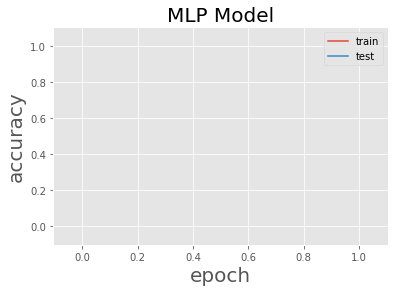

In [170]:
plt.plot(mt,label = 'train')
plt.plot(mtrash,label = 'test')
plt.title('MLP Model',{'fontsize' : 20})
plt.legend()
plt.xlabel('epoch',{'fontsize' : 20})
plt.ylabel('accuracy',{'fontsize' : 20})

# 딥러닝 모델

In [171]:
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop, Nadam, Adamax, Adagrad, Adadelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization



CNN_search_point = {'learning_rate': (0.001,0.1),
                  'dense_node':(1,1024),
                  'dropout_rate':(0.1,0.5)}

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)

def CNN_opt(learning_rate,dense_node,dropout_rate):
    cvscores = []
    print(float(learning_rate),int(dense_node),float(dropout_rate))
    for train_index, valid_index in skfolds.split(X_train, Y_train_recovery):
        cnn = cnn_model(float(learning_rate),int(dense_node),float(dropout_rate))
        X_train_fold,X_valid_fold = X_train[train_index],X_train[valid_index]
        y_train_fold,y_valid_fold = Y_train[train_index],Y_train[valid_index]

        cnn.fit(X_train_fold,y_train_fold,batch_size=2, nb_epoch=5,verbose=0)
        score = cnn.evaluate(X_valid_fold,y_valid_fold,verbose=0)
        cvscores.append(score[1]*100)
    return np.mean(cvscores)


# if __name__ == "__main__":
#     result = BayesianOptimization(CNN_opt, CNN_search_point,    random_state=0,    verbose=2) 
#     result.maximize(acq='ucb',n_iter=20)
#     for i, res in enumerate(result.res):
#         print('Iteration {}: \n\t{}'.format(i, res))
#         print('Final result: ', result.max)

ModuleNotFoundError: No module named 'keras'

In [172]:
models = [mlp_model(),cnn_model(0.019589,225,0.18557)]

TypeError: mlp_model() missing 3 required positional arguments: 'dense1', 'dense2', and 'dropout_rate'

In [173]:
def CNN_opt(learning_rate,dense_node,dropout_rate):
    cvscores = []
    for train_index, valid_index in skfolds.split(X_train, Y_train_recovery):
        X_train_fold,X_valid_fold = X_train[train_index],X_train[valid_index]
        y_train_fold,y_valid_fold = Y_train[train_index],Y_train[valid_index]

        print(float(learning_rate),int(dense_node),float(dropout_rate))
        cnn = cnn_model(float(learning_rate),int(dense_node),float(dropout_rate)).fit(X_train_fold,y_train_fold,batch_size=400, nb_epoch=20,verbose=2)
        score = cnn_model(float(learning_rate),int(dense_node),float(dropout_rate)).evaluate(X_valid_fold,y_valid_fold,verbose=2)
        print(score)
        cvscores.append(score[1]*100)
    return np.mean(cvscores)

In [174]:
sc = CNN_opt(0.019589668000042214,225.47628273963673,0.18557181851054969)
print(sc)

NameError: name 'skfolds' is not defined

In [175]:
# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy',allow_pickle=True) # Train:Test = 4:1 로 분할된 데이터

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)
kfolds = KFold(n_splits=5)

Y_train_recovery = np.argmax(Y_train, axis=1)

cnn_cvscores = []
CNN_history = []
start_time = time.time()

count=0
for train_index, valid_index in skfolds.split(X_train, Y_train_recovery):
    X_train_fold,X_valid_fold = X_train[train_index],X_train[valid_index]
    y_train_fold,y_valid_fold = Y_train[train_index],Y_train[valid_index]
    cnn = cnn_model(0.019589,225,0.18557)

    CNN_history.append(cnn.fit(X_train_fold, y_train_fold, batch_size=2000, epochs=50,verbose=2))

    scores = cnn.evaluate(X_valid_fold, y_valid_fold, verbose=1)
    print("%s: %.2f%%" % (cnn.metrics_names[1], scores[1]*100))
    cnn_cvscores.append(scores[1] * 100)
    
    # save model
    filename = 'models/CNNmodel_' + str(count + 1) + '.h5'
    cnn.save(filename)
    print('>Saved %s' % filename)
    count+=1


print("%.2f%% (+/- %.2f%%)" % (np.mean(cnn_cvscores), np.std(cnn_cvscores)))
cnn_best_val_score = np.max(cnn_cvscores)
print('run time :',round(time.time()-start_time,3)/60)


for i in range(len(CNN_history)):
    plt.plot(CNN_history[i].history['accuracy'])
    plt.plot(CNN_history[i].history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy',{'fontsize' : 20})
    plt.xlabel('Epoch',{'fontsize' : 20})
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
# CNN_model.save('CNN_model.h5')

NameError: name 'StratifiedKFold' is not defined

In [176]:
temp = []
trash = []

In [177]:
for i in range(5):
    for j in range(30):
        temp.append(CNN_history[i].history['accuracy'][j])
#         trash.append(CNN_history[i].history['val_accuracy'][j])

NameError: name 'CNN_history' is not defined

<function matplotlib.pyplot.box(on=None)>

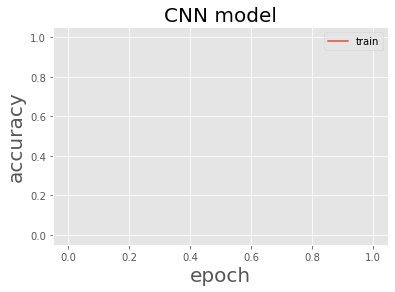

In [178]:
plt.plot(temp,label = 'train')
# plt.plot(trash,label = 'test')
plt.title('CNN model',{'fontsize' : 20})
plt.legend()
plt.ylabel('accuracy',{'fontsize' : 20})
plt.xlabel('epoch',{'fontsize' : 20})

plt.box

In [179]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

for i in range(len(CNN_history)):
    plt.plot(CNN_history[i].history['acc'])
    plt.plot(CNN_history[i].history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy',{'fontsize' : 20})
    plt.xlabel('Epoch',{'fontsize' : 20})
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

NameError: name 'cvscores' is not defined

In [180]:
for i in range(len(MLP_history)):
    plt.plot(CNN_history[i].history['acc'])
    plt.plot(CNN_history[i].history['val_acc'])
#     plt.title('model accuracy')
    plt.ylabel('Accuracy',{'fontsize' : 20})
    plt.xlabel('Epoch',{'fontsize' : 20})
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

NameError: name 'MLP_history' is not defined

In [181]:
testresult = (CNN_model.predict_classes(X_test))

NameError: name 'CNN_model' is not defined

In [182]:
testYdata= np.argmax(Y_test,axis=1)
count=0
for i in range(1000):
    if testYdata[i] == testresult[i]:
        count +=1
print(count/1000*100,'%')

NameError: name 'Y_test' is not defined

In [183]:
history = []
score = []
from sklearn import datasets
from sklearn.base import clone
seed = 7
np.random.seed(seed)

# X = np.expand_dims(imgs,axis=3)#흑백


X = np.array(imgs)
y = np.array(labels)



model = Sequential()

model.add(Conv2D(16, (3, 3), padding = 'same', input_shape = (50,55,3)))
model.add(Activation('relu'))
model.add(Dropout(0.50))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2),strides=2))
model.add(Dropout(0.50))

model.add(Conv2D(32, (3 ,3),padding = 'same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3),padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2),strides= 2))
model.add(Dropout(0.50))

model.add(Conv2D(64, (3 ,3),padding = 'same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3 ,3),padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2),strides = 2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(9,activation = 'softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.01), metrics=['accuracy'])
model.summary()
skfolds=StratifiedKFold(n_splits=3, random_state=42,shuffle =True)

cvscores = []
history = []

# Save Model with CheckPoint & StopPoint

# from keras.callbacks import ModelCheckpoint,EarlyStopping

# import os

# import datetime

# Datetime = datetime.datetime.now().strftime('%m%d_%H%M')

# modelpath="Gersang.h5"

# checkpointer = ModelCheckpoint(filepath=modelpath, monitor='loss', verbose=1, save_best_only=True)
# early_stopping_callback = EarlyStopping(monitor='loss', patience=10)

# # Learning and save models

# model.fit(X,y_one_hot, validation_split=0.1, epochs=3500, batch_size=10, verbose=0, callbacks=[early_stopping_callback,checkpointer])

# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy')

for train_index, test_index in skfolds.split(X, y):
    X_train_fold = X[train_index]
    y_train_fold = y[train_index]
    X_test_fold =X[test_index]
    y_test_fold = y[test_index]
    print(X_train_fold.shape)
    NB_CLASSES = int(max(y)+1)
    y_train_fold = np_utils.to_categorical(y_train_fold, NB_CLASSES)
    y_test_fold = np_utils.to_categorical(y_test_fold, NB_CLASSES)
    history = (model.fit(X_train_fold, y_train_fold, validation_split=0.2,  batch_size=400, nb_epoch=20))
    
    scores = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Trends of accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
    
model.save('Gersang.h5')

NameError: name 'imgs' is not defined

In [184]:
# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy')

history = (model.fit(X_train, Y_train, validation_split=0.2,  batch_size=350, nb_epoch=20))
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
cvscores.append(scores[1] * 100)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Trends of accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'X_train' is not defined

In [185]:
diff = testresult.flatten() - testYdata.flatten()
absPercentDiff = np.abs(diff)
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

NameError: name 'testresult' is not defined

In [186]:
print(np.sum(trainy[0]))
print(np.sum(trainy[0])/len(trainy[0]))

NameError: name 'trainy' is not defined

In [187]:
model.save('Classification_foot_9class.h5')

AttributeError: 'GaussianProcessRegressor' object has no attribute 'save'

In [188]:
# define two sets of inputs
inputA = Input(shape=(14,))
inputB = Input(shape=(32,32,3))
 
# the first branch operates on the first input
x = Dense(14, input_dim=14, activation="relu", kernel_initializer="normal")(inputA)
x = Dense(128, activation="relu", kernel_initializer="normal")(x)
x = Dense(128, activation="relu", kernel_initializer="normal")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(9, activation="softmax", kernel_initializer="normal")(x)
x = Model(inputs = inputA, outputs = x)

# the second branch opreates on the second input

prior = keras.applications.VGG16( include_top=False,  weights='imagenet')(inputB)
y = Flatten()(prior)
y = Dense(512, activation='relu', name='Dense_Intermediate')(y)
y = (BatchNormalization())(y)
y = Dropout(0.5, name='Dropout_Regularization')(y)
y = Dense(9, activation='softmax', name='Output')(y)
y = Model(inputs = inputB, outputs = y)

NameError: name 'Input' is not defined

In [189]:
# combine the output of the two branches
combined = concatenate([x.output, y.output], axis = 1)
 
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(64 ,activation="tanh")(combined)
z = Dense(16 ,activation="relu")(z)
z = (Dropout(0.3))(z)
z = (BatchNormalization())(z)
z = Dense(9, activation="softmax")(z)

# our model will accept the inputs of the two branches and
# then output a single value
M = Model(inputs=[x.input, y.input], outputs=z)

M.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(lr=0.001), metrics=['accuracy'])
M.summary()

NameError: name 'concatenate' is not defined

In [190]:
# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy')

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)
kfolds = KFold(n_splits=5,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)
Mcvscores = []
M_history = []
start_time = time.time()


for train_index, valid_index in skfolds.split(X_train, Y_train_recovery):
    
    X_train_fold,X_valid_fold = X_train[train_index],X_train[valid_index]
    x_train_fold,x_valid_fold = x_train[train_index],x_train[valid_index]
    y_train_fold,y_valid_fold = Y_train[train_index],Y_train[valid_index]
 
#     NB_CLASSES = int(max(y)+1)
#     y_train_fold = np_utils.to_categorical(y, NB_CLASSES)
#     y_test_fold = np_utils.to_categorical(y, NB_CLASSES)
    M_history.append(M.fit([x_train_fold,X_train_fold],y_train_fold,validation_data = [[x_valid_fold,X_valid_fold],y_valid_fold], epochs=10, batch_size=2000,verbose=2))

    Mscores = M.evaluate([x_test,X_test],Y_test, verbose=0)
    print("%s: %.2f%%" % (M.metrics_names[1], Mscores[1]*100))
    Mcvscores.append(Mscores[1] * 100)

for i in range(len(M_history)):
    plt.plot(M_history[i].history['accuracy'])
    plt.plot(M_history[i].history['val_accuracy'])
#     plt.title('model accuracy')
    plt.ylabel('Accuracy',{'fontsize' : 20})
    plt.xlabel('Epoch',{'fontsize' : 20})
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

print("%.2f%% (+/- %.2f%%)" % (np.mean(Mcvscores), np.std(Mcvscores)))
print('run time :',round(time.time()-start_time,3)/60)

# M.save('M_Gersang.h5')

NameError: name 'StratifiedKFold' is not defined

In [191]:
temp = []
trash = []

In [192]:
for i in range(5):
    for j in range(30):
        temp.append(M_history[i].history['accuracy'][j])
        trash.append(M_history[i].history['val_accuracy'][j])

NameError: name 'M_history' is not defined

Text(0, 0.5, 'accuracy')

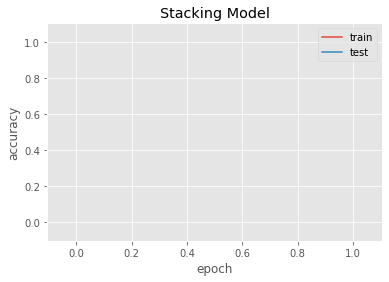

In [193]:
plt.plot(mt,label = 'train')
plt.plot(mtrash,label = 'test')
plt.title('Stacking Model')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [194]:
M.save('Gersang.h5')
result = M.predict([x[0:100],X[0:100]])
print(pd.DataFrame((result)))
print(y[0:100])

NameError: name 'M' is not defined

In [195]:
M.fit([traindata,trainimgdata],trainy,validation_data=([testdata,testimgdata],testy),epochs=20,batch_size=100)
preds = model.predict([testdata,testimagedata])

NameError: name 'M' is not defined

In [196]:
np.mean(Ensemble_cvscores)

NameError: name 'Ensemble_cvscores' is not defined

In [197]:
d

NameError: name 'd' is not defined

In [198]:
d = (KNN_cvscores,CART_cvscores,CNN_cvscores,RES_cvscores,Ensemble_cvscores)
d = pd.DataFrame(d)
d = d.transpose()
d.describe()

NameError: name 'KNN_cvscores' is not defined

In [199]:
d[0]

NameError: name 'd' is not defined

In [200]:
# plt.title('Accuracy comparison between models',{'fontsize' : 20})
plt.xlabel('Model',{'fontsize' : 15})
plt.ylabel('f1 score',{'fontsize' : 15})
plt.boxplot((KNN_cvscores,CART_cvscores,CNN_cvscores,RES_cvscores,Ensemble_cvscores),labels = ['KNN','CART','VGG16','InceptionV3','Ensemble'])
plt.grid()
# plt.legend(['MLP Model','CNN Model','Ensemble'])

NameError: name 'KNN_cvscores' is not defined

In [201]:
tip = [KNN_cvscores,CART_cvscores,CNN_cvscores,RES_cvscores,Ensemble_cvscores]
Model = ["K-NN","CART","VGG16","InceptionV3","Stacking Ensemble"]
sns.boxplot(width = 0.5,data=tip)

NameError: name 'KNN_cvscores' is not defined